# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 32
seq_idx = range(7,26,2)
dim_x, dim_y = 120, 120
print("Num of frames per video:", len(seq_idx))

Num of frames per video: 10


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size, print_img = False, show_stat = False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        t = np.random.permutation(folder_list)
        if show_stat:
            print("#"*50)
            print("Length:", len(t))
            print("Batch size:", batch_size)
            print("Remaining videos:", len(t)%batch_size)
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
            batch_size = len(t)%batch_size
        if show_stat:
            print("No. of Batches:", num_batches)
            print("#"*50)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                if print_img:
                    plt.figure(figsize=(20,5))
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if print_img:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                    else:
                        diff_px = 0
                    crop_start = diff_px//2
                    crop_end = crop_start + image.shape[1]
                    image = image[:, crop_start:crop_end]
                    
                    resized_im = resize(image, (dim_x, dim_x))
                    
                    if print_img:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im.astype('uint8'))
                    
                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 #normalise and feed in the image
                    
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                print_img = False
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


Source path =  /home/datasets/Project_data/train ; batch size = 32
##################################################
Length: 663
Batch size: 32
Remaining videos: 23
No. of Batches: 21
##################################################


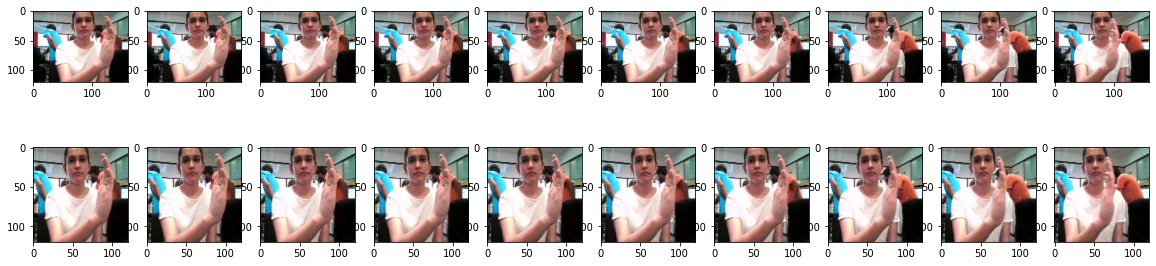

In [6]:
test_gen = generator(train_path, train_doc, batch_size, print_img = True, show_stat = True)
d = next(test_gen)[0]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, TimeDistributed, LSTM, Conv2D, MaxPooling2D, ConvLSTM2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers

input_shape = (len(seq_idx), dim_x, dim_y, 3)
input_shape

(10, 120, 120, 3)

### Experiment #1

In [8]:
#1
#model = Sequential()
#model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
#model.add(MaxPooling3D(pool_size=2))

#model.add(Conv3D(64, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=2))

#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dense(5, activation='softmax'))

### Experiment #2

In [9]:
#2
#model = Sequential()
##Layer1
#model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape, padding="same"))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=2))
#model.add(Dropout(0.5))
##Layer2
#model.add(Conv3D(64, kernel_size=3, activation='relu', padding="same"))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
##Layer3
#model.add(Conv3D(64, kernel_size=3, activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=2))
#model.add(Dropout(0.5))

#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dense(5, activation='softmax'))

### Experiment #3, 4 & 5
Adding one more Conv3D layer
<ol start="3"><li>AddingBatchNormalization after every Conv3D layer with Dropout
<li>Increasing number of images per video.
Reducing batch size to 60.
Reducing filter size in 2nd Conv3d layer</li>
<li>Accuracy seems to be improving hence increasing number of epochs to 60</ol>

In [11]:
#3, 4 and 5
#model = Sequential()
##Layer1
#model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape, padding="same"))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=2))
#model.add(Dropout(0.5))
#Layer2
#model.add(Conv3D(32, kernel_size=3, activation='relu', padding="same"))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
#Layer3
#model.add(Conv3D(64, kernel_size=3, activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=2))
#model.add(Dropout(0.5))

#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.25))
#model.add(Flatten())
#model.add(Dense(5, activation='softmax'))

### Experiment #6
Trying ConvLSTM as Conv3D not giving desired accuracy

In [12]:
##6
#model = Sequential()
##Layer1
#model.add(TimeDistributed(Conv2D(32, kernel_size=3, activation='relu', padding="same"), input_shape=input_shape))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
#model.add(Dropout(0.5))
##Layer2
#model.add(TimeDistributed(Conv2D(32, kernel_size=3, activation='relu', padding="same")))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(Dropout(0.5))
##Layer3
#model.add(TimeDistributed(Conv2D(64, kernel_size=3, activation='relu')))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
#model.add(Dropout(0.5))

#model.add(TimeDistributed(Flatten()))
#model.add(LSTM(256))
#model.add(Dropout(0.25))
#
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.25))
#
#model.add(Dense(5, activation='softmax'))

### Experiment #7
Increasing batch size to 64
Increasing number of frames to 20
Adding one more Conv2D layer with BatchNormalization and MaxPooling2D

In [14]:
##7
#model = Sequential()
##Layer1
#model.add(TimeDistributed(Conv2D(32, kernel_size=3, activation='relu', padding="same"), input_shape=input_shape))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
#
##Layer2
#model.add(TimeDistributed(Conv2D(64, kernel_size=3, activation='relu', padding="same")))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
#
##Layer3
#model.add(TimeDistributed(Conv2D(128, kernel_size=3, activation='relu', padding="same")))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
#
##Layer4
#model.add(TimeDistributed(Conv2D(256, kernel_size=3, activation='relu', padding="same")))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
#
#model.add(TimeDistributed(Flatten()))
#model.add(LSTM(256))
#model.add(Dropout(0.25))
#
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.25))
#model.add(Dense(5, activation='softmax'))

### Experiment #8
Adding one more Conv2D layer
Increasing number of epochs to 35

In [16]:
##8
#model = Sequential()
##Layer1
#model.add(TimeDistributed(Conv2D(16, kernel_size=3, activation='relu', padding="same"), input_shape=input_shape))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
#
##Layer2
#model.add(TimeDistributed(Conv2D(32, kernel_size=3, activation='relu', padding="same")))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
#
##Layer3
#model.add(TimeDistributed(Conv2D(64, kernel_size=3, activation='relu', padding="same")))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
#
##Layer4
#model.add(TimeDistributed(Conv2D(128, kernel_size=3, activation='relu', padding="same")))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
#
##Layer5
#model.add(TimeDistributed(Conv2D(256, kernel_size=3, activation='relu', padding="same")))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
#
#model.add(TimeDistributed(Flatten()))
#model.add(LSTM(256))
#model.add(Dropout(0.25))
#
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.25))
#model.add(Dense(5, activation='softmax'))

### Experiment #9
Building a similar model with Conv3D to compare results

In [18]:
##9
#model = Sequential()
##Layer1
#model.add(Conv3D(16, kernel_size=3, activation='relu', padding="same", input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=2))
#
##Layer2
#model.add(Conv3D(32, kernel_size=3, activation='relu', padding="same"))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=2))
#
##Layer3
#model.add(Conv3D(64, kernel_size=3, activation='relu', padding="same"))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=2))
#
##Layer4
#model.add(Conv3D(128, kernel_size=3, activation='relu', padding="same"))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=2))
#
##Layer5
#model.add(Conv3D(256, kernel_size=3, activation='relu', padding="same"))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=2, padding='same'))
#
#model.add(Flatten())
#model.add(Dropout(0.25))
#
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.25))
#model.add(Dense(5, activation='softmax'))

### Experiment #10 & 11
<br>10. Training accuracy is more than validation accuracy. The model didnt improve after 40 epochs. Hence changing the architecture.
<br>11. The model is working quite well on validation dataset with less trainable parameters(98,885), Lets add some drop outs after each layer, so that both train and validation accuracies will be closure.

In [19]:
##10 & 11
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(64, activation='relu')))
# model.add(BatchNormalization())

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

### Experiment #12
#### Final model
This is good model with training and validation accuracies with number of params 128,517. Let’s use different architecture of model with time distributed and ConvLSTM2D. 

In [20]:
#12
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

2022-11-14 16:35:38.747771: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-14 16:35:38.747833: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [21]:
optimiser = optimizers.Adam(lr=0.01)
model.build(input_shape)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 118, 118, 8)  224       
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 10, 118, 118, 8)  32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 116, 116, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 10, 116, 116, 16)  64       
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)       6

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [22]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [23]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [25]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/50


2022-11-14 16:35:44.170969: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.3605 - categorical_accuracy: 0.3499Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2022-11-1416_35_34.938551/model-00001-1.36055-0.34990-1.85136-0.12500.h5
21/21 [==============================] - 40s 2s/step - loss: 1.3605 - categorical_accuracy: 0.3499 - val_loss: 1.8514 - val_categorical_accuracy: 0.1250 - lr: 0.0100
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.1290 - categorical_accuracy: 0.4486
Epoch 00002: saving model to model_init_2022-11-1416_35_34.938551/model-00002-1.12899-0.44862-1.79940-0.18750.h5
21/21 [==============================] - 29s 1s/step - loss: 1.1290 - categorical_accuracy: 0.4486 - val_loss: 1.7994 - val_categorical_accuracy: 0.1875 - lr: 0.0100
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.0945 - categorical_accuracy: 0.4665
Epoch 00003: saving model to model_init_2022-11-1416_35_34.938551/mode

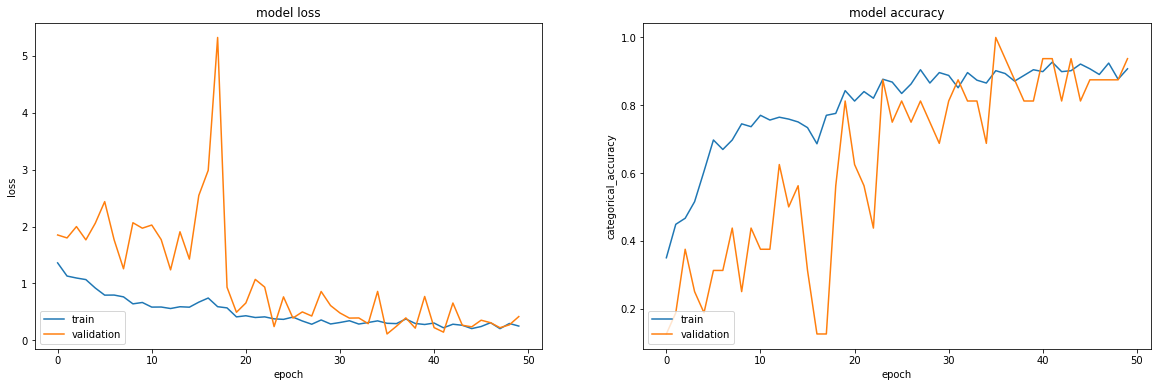

In [26]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

In [27]:
rm -rf ~/.local/share/Trash/*